# Telecom Churn Prediction Using Random Forest vs Neural Networks

Statistically 59% of customers don’t return after a bad customer service experience.

Data - Kaggle Telco Dataset
- Churn: Whether the customer churned or not (Yes or No)

In [1]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import SVMSMOTE

import keras 
from keras.models import Sequential 
from keras.layers import InputLayer 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.constraints import maxnorm

import itertools
from matplotlib import pyplot as plt 

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Data Cleaup
# - Convert categorical variables into numerical variables (e.g. Yes/No to 1/0) 
# - Fill null values with 0
# - Ensured values are in numeric format

data.SeniorCitizen.replace([0, 1], ["No", "Yes"], inplace= True)
data.TotalCharges.replace([" "], ["0"], inplace= True)
data.TotalCharges = data.TotalCharges.astype(float)
data.drop("customerID", axis= 1, inplace= True) 
data.Churn.replace(["Yes", "No"], [1, 0], inplace= True)

In [4]:
#pd.get_dummies creates a new dataframe which consists of zeros and ones
data = pd.get_dummies(data)

In [5]:
# Rank features using recursive feature elimination (RFE) method and Random Forest Classifier algorithm as estimator

X = data.drop("Churn", axis= 1)
y = data.Churn

#print(X.columns)

rfc = RandomForestClassifier(n_estimators=40)
rfe = RFE(rfc, 16)
rfe_fit = rfe.fit(X, y)

print("Num Features: %s" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 16
Selected Features: [ True  True  True False  True  True False  True False  True False False
 False  True False False False  True False  True False False  True False
 False  True False False  True False False False False False False False
 False  True False False False  True False False  True False]
Feature Ranking: [ 1  1  1  4  1  1 11  1  8  1 13 24 22  1 26  7 18  1 23  1 30 21  1 28
 12  1 25 15  1 31 20  2 27 16  3 29 14  1 19 10  6  1  9  5  1 17]


In [6]:

X = data[[
        'tenure', 
        'MonthlyCharges', 
        'TotalCharges', 
        'gender_Female',
        'gender_Male', 
        'SeniorCitizen_Yes', 
        'Partner_Yes', 
        'Dependents_Yes', 
        'MultipleLines_No',
        'InternetService_Fiber optic',
        'OnlineSecurity_No',
        'OnlineSecurity_Yes',
        'OnlineBackup_Yes', 
        'DeviceProtection_Yes',
        'StreamingTV_No internet service', 
        'StreamingMovies_No internet service',
        'Contract_Month-to-month', 
        'Contract_One year',
        'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 
        ]]


y = data.Churn

In [7]:
# Check for class imbalance
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [8]:
# Use oversampling

sm=SVMSMOTE(sampling_strategy='auto')   #SVMSMOTE to use old version
X_sampled,y_sampled=sm.fit_sample(X,y)

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X_sampled,y_sampled,test_size=0.2,random_state=0)


## Random Forest Model

In [10]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train, y_train) 

score = rf.score(X_train, y_train)
score2 = rf.score(X_test, y_test)

print("Training set accuracy: ", '%.3f'%(score))
print("Test set accuracy: ", '%.3f'%(score2))

Training set accuracy:  0.996
Test set accuracy:  0.849


In [11]:
rf_predictions = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)

[[856 177]
 [136 901]]


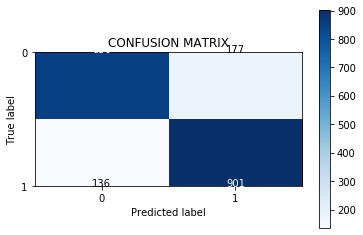

In [12]:
# Evaluate Model Performance 

y_pred = rf.predict(X_test)


# Confusion Matrix
def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print(confusion_matrix(y_test,y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],normalize= False,  title='CONFUSION MATRIX')



In [13]:
# Precision, Recall and F1-Score


print(classification_report(y_test,y_pred))
print('MODEL ACCURACY == '+str(round(accuracy_score(y_test, y_pred)*100,2))+'%')

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1033
           1       0.84      0.87      0.85      1037

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070

MODEL ACCURACY == 84.88%


In [14]:
# Feature Selection

fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(20)

,feature,importance
2,TotalCharges,0.180475
0,tenure,0.173384
1,MonthlyCharges,0.154931
16,Contract_Month-to-month,0.082103
9,InternetService_Fiber optic,0.046989
10,OnlineSecurity_No,0.042153
11,OnlineSecurity_Yes,0.038743
14,StreamingTV_No internet service,0.024524
7,Dependents_Yes,0.022320
12,OnlineBackup_Yes,0.022159


## Neural Network Model

In [15]:
# Define model

model = Sequential()
model.add(Dense(64, input_dim=21, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(8, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=8)

Train on 8278 samples, validate on 2070 samples
Epoch 1/50
8278/8278 [==============================] - 2s 203us/step - loss: 3.1166 - accuracy: 0.5389 - val_loss: 0.6491 - val_accuracy: 0.5913
Epoch 2/50
8278/8278 [==============================] - 1s 174us/step - loss: 0.6829 - accuracy: 0.5771 - val_loss: 0.6460 - val_accuracy: 0.5928
Epoch 3/50
8278/8278 [==============================] - 1s 174us/step - loss: 0.6595 - accuracy: 0.5811 - val_loss: 0.6452 - val_accuracy: 0.5937
Epoch 4/50
8278/8278 [==============================] - 2s 189us/step - loss: 0.6624 - accuracy: 0.5911 - val_loss: 0.6330 - val_accuracy: 0.6169
Epoch 5/50
8278/8278 [==============================] - 2s 184us/step - loss: 0.6457 - accuracy: 0.5997 - val_loss: 0.6284 - val_accuracy: 0.6271
Epoch 6/50
8278/8278 [==============================] - 2s 208us/step - loss: 0.6404 - accuracy: 0.6138 - val_loss: 0.6220 - val_accuracy: 0.6357
Epoch 7/50
8278/8278 [==============================] - 2s 188us/step - loss

MAX ACCURACY        == 0.7656439
LAST EPOCH ACCURACY == 0.75646293


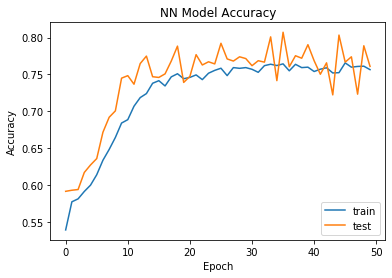

In [16]:
# Plot how accuracy varies as a function of epochs

print('MAX ACCURACY        == '+str(max(history.history['accuracy'])))
print('LAST EPOCH ACCURACY == '+str(history.history['accuracy'][-1]))

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('NN Model Accuracy') 
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend(['train', 'test'], loc='lower right') 
plt.show()

## Conclusion

- Random Forests requires less preprocessing and the training process is also much simpler.
- Hyper-parameter tuning is easier with random forest when compared to neural networks

